In [2]:
import os
import time
import datetime
import random
import json
from typing import Dict, List

import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from transformers import BertTokenizer, GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM
from transformers import AdamW, get_linear_schedule_with_warmup

torch.manual_seed(42)


## Preprocess

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
songs_df = pd.read_csv('../data/songs.csv')
songs_info_df = pd.read_csv('../data/song_extra_info.csv')

In [16]:
train_df.isna().sum() / len(train_df)

msno                  0.000000
song_id               0.000000
source_system_tab     0.003368
source_screen_name    0.056226
source_type           0.002920
target                0.000000
dtype: float64

In [27]:
(songs_df.isna().sum() / len(songs_df)).round(2)

song_id        0.00
song_length    0.00
genre_ids      0.04
artist_name    0.00
composer       0.47
lyricist       0.85
language       0.00
dtype: float64

In [38]:
'0' in set('|'.join(songs_df['genre_ids'].astype(str).tolist()).split('|'))

False

In [39]:
songs_df['genre_ids'] = songs_df['genre_ids'].fillna('0').astype(str)

In [40]:
(songs_df.isna().sum() / len(songs_df)).round(2)

song_id        0.00
song_length    0.00
genre_ids      0.00
artist_name    0.00
composer       0.47
lyricist       0.85
language       0.00
dtype: float64

In [41]:
full_df = train_df.merge(songs_df, 'inner', on='song_id')

In [44]:
full_df = full_df.merge(songs_info_df, 'inner', on='song_id')
full_df

msno  \
0        FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1        e5Ezre9HPuPos+CXQXtmo32E/hHIZTMmo6jG3yRf6UA=   
2        pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=   
3        sSexP400TJOZRhx3JB+0s9cqrCnqrlV51B9njoKR1II=   
4        hKdGiUKHVqKkXGHLrc+EzdSW6q0ERAJ2Cs7/L1N0Ae4=   
...                                               ...   
7375844  wCGT5Nb+vL9GXEZ87Kp8BAqFOVZugZSxG1706efctMU=   
7375845  wCGT5Nb+vL9GXEZ87Kp8BAqFOVZugZSxG1706efctMU=   
7375846  OHw2qQArWtGlk/gthkEt8WmDnx/1SxLgeqXisMzhHyM=   
7375847  AkvLFGpB1EDBAQBa1xgCq3hq8hoFRsV+AO0ezHdCVN4=   
7375848  j7NK18jKavoyccmVEC/BCtiXbUsfLfmAGFAsgZKSJ0E=   

                                              song_id source_system_tab  \
0        BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1        BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
2        BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          discover   
3        BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          discover   
4        BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          discover   
...                                               ...               ...   
7375844  FmdO/4DNXqJWwA0FH2LEdvy/WuUU/Aq2DKlbFvQT6oY=          discover   
7375845  qzY5KBI8QBg1fs/qrhNm1KLe7lVbjYRbNtA595gl9vQ=          discover   
7375846  SZZUaT+kWlIDkjgJqK5VJls94gArFT1BgkrFLjvJVIc=        my library   
7375847  7+DNPp8HiFDXlQmNejGezfdJ15eXGms1PmRCwtc+zVQ=          discover   
7375848  WJzitiYM7ddyalCdx8/Gkkt1UFSp2t/0ZY74CrMGvWg=        my library   

           source_screen_name          source_type  target  song_length  \
0                     Explore      online-playlist       1       206471   
1         Local playlist more       local-playlist       1       206471   
2        Online playlist more      online-playlist       0       206471   
3        Online playlist more      online-playlist       0       206471   
4                         NaN      online-playlist       0       206471   
...                       ...                  ...     ...          ...   
7375844        Discover Genre                album       0       397479   
7375845        Discover Genre                album       0       420911   
7375846  Online playlist more      online-playlist       0       226348   
7375847  Online playlist more  song-based-playlist       1       198949   
7375848                Search                 song       0       136032   

        genre_ids              artist_name              composer    lyricist  \
0             359                 Bastille  Dan Smith| Mark Crew         NaN   
1             359                 Bastille  Dan Smith| Mark Crew         NaN   
2             359                 Bastille  Dan Smith| Mark Crew         NaN   
3             359                 Bastille  Dan Smith| Mark Crew         NaN   
4             359                 Bastille  Dan Smith| Mark Crew         NaN   
...           ...                      ...                   ...         ...   
7375844      2079               Chaandanee            Chaandanee  Chaandanee   
7375845      2079               Chaandanee            Chaandanee  Chaandanee   
7375846       958             Francis Goya       Wallux| F.Weyer         NaN   
7375847       465  Salvina y Miren al Lobo                   NaN         NaN   
7375848  1609|947       証聲音樂圖書館 ECHO MUSIC                Sutton         NaN   

         language                                name          isrc  
0            52.0                          Good Grief  GBUM71602854  
1            52.0                          Good Grief  GBUM71602854  
2            52.0                          Good Grief  GBUM71602854  
3            52.0                          Good Grief  GBUM71602854  
4            52.0                          Good Grief  GBUM71602854  
...           ...                                 ...           ...  
7375844      52.0                         Rose Valley  DEAR41645242  
7375845      52.0                     Non

In [89]:
temp_df = full_df.groupby('msno').get_group(
    'j7NK18jKavoyccmVEC/BCtiXbUsfLfmAGFAsgZKSJ0E=')

In [52]:
temp_df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'name', 'isrc'],
      dtype='object')

In [99]:
def select_target_songs(song_target: pd.DataFrame) -> List[str]:

    song_target = song_target[song_target['target'] == 1]
    name_artist_pairs = song_target['name'] + ' -> ' + song_target[
        'artist_name']
    name_artist_pairs.drop_duplicates(inplace=True)

    return name_artist_pairs.to_list()


In [100]:
user_songs = full_df.groupby('msno').apply(select_target_songs).to_dict()

In [95]:
user_songs

{'++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=': ['手心的薔薇 (Beautiful) feat. G.E.M.鄧紫棋-林俊傑 (JJ Lin)',
  '演員-薛之謙',
  '告白氣球-周杰倫 (Jay Chou)',
  '我過的很好-莊心妍',
  '好好 (想把你寫成一首歌) (Song About You)-五月天 (Mayday)',
  '迷途羔羊-兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116)',
  '謝謝妳愛我 (Thanks For Your Love)-謝和弦 (R-chord)',
  '聽見下雨的聲音-周杰倫 (Jay Chou)',
  '不該-周杰倫 (Jay Chou)',
  '寶貝-張懸 (Deserts Xuan)',
  'Sing Me to Sleep-Alan Walker',
  '回來我身邊-玖壹壹',
  '如果我們不曾相遇 (What If We Had Never Met)-五月天 (Mayday)',
  '後來的我們 (Here| After| Us)-五月天 (Mayday)',
  'Just Believe-頑童MJ116',
  'Whistle-Flo Rida',
  '星晴-周杰倫 (Jay Chou)',
  '明天再擱來-玖壹壹',
  '癡情玫瑰花-Under Lover (地下情人)',
  '愛_不需要理由 (LOVE_NO REASON)-io樂團 (io)',
  "愛不需要裝乖 (feat.王詩安) (Love Doesn't Need To Pretend)-謝和弦 (R-chord)",
  'Turn Around [5|4|3|2|1]-Flo Rida',
  '淘汰(國)-陳奕迅 (Eason Chan)',
  '我的路-玖壹壹',
  '下輩子-玖壹壹',
  '走著走著就散了-莊心妍',
  '再見只是陌生人-莊心妍',
  'Skit-頑童MJ116',
  'FLY OUT-兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116)',
  '熱戀過後-莊心妍',
  '江南-林俊傑 (JJ Lin)',
  '修煉愛情 (Practice Love)-林俊傑 (JJ Lin)',
  

In [101]:
with open('../data/user-song.json', 'w', encoding='utf-8') as f:
    json.dump(user_songs, f)

In [90]:
temp_df = temp_df[['name', 'artist_name', 'target']]

In [91]:
temp_df[temp_df['target'] == 1]

name        artist_name  target
10164    手心的薔薇 (Beautiful) feat. G.E.M.鄧紫棋       林俊傑 (JJ Lin)       1
14867                             給我一首歌的時間     周杰倫 (Jay Chou)       1
62045                                 告白氣球     周杰倫 (Jay Chou)       1
101599                                帥到分手  周湯豪 (NICKTHEREAL)       1
194283                               你給我聽好   陳奕迅 (Eason Chan)       1
...                                    ...                ...     ...
6287855                The Book of Love 情書         Air Supply       1
6330135                                Jam    Michael Jackson       1
6615237                     I Can't Let Go         Air Supply       1
6650805                              志明與春嬌               簡單情歌       1
6863758   孤獨是會上癮的 (Addicted To Loneliness)     吳克群 (Kenji Wu)       1

[224 rows x 3 columns]

In [73]:
temp_df.apply(lambda row: row['name'] + '-' + row['artist_name'], axis=1)

10164         手心的薔薇 (Beautiful) feat. G.E.M.鄧紫棋-林俊傑 (JJ Lin)
14867                                給我一首歌的時間-周杰倫 (Jay Chou)
21317                             關鍵詞 (The Key)-林俊傑 (JJ Lin)
31910                           因你而在 (You N Me)-林俊傑 (JJ Lin)
62045                                    告白氣球-周杰倫 (Jay Chou)
                                 ...                        
6853159                                LAST CHRISTMAS-廣州交響樂團
6863758      孤獨是會上癮的 (Addicted To Loneliness)-吳克群 (Kenji Wu)
6869678                              容易受傷的女人-Various Artists
6912662        I Just Called To Say I Love You-Stevie Wonder
7375848    Samba Carnival (2014巴西世界盃，榮耀森巴主題曲)-証聲音樂圖書館 ECH...
Length: 543, dtype: object

In [76]:
(temp_df['name'] + '-' + temp_df['artist_name']).to_list()

['手心的薔薇 (Beautiful) feat. G.E.M.鄧紫棋-林俊傑 (JJ Lin)',
 '給我一首歌的時間-周杰倫 (Jay Chou)',
 '關鍵詞 (The Key)-林俊傑 (JJ Lin)',
 '因你而在 (You N Me)-林俊傑 (JJ Lin)',
 '告白氣球-周杰倫 (Jay Chou)',
 '我過的很好-莊心妍',
 '好好 (想把你寫成一首歌) (Song About You)-五月天 (Mayday)',
 '夜空中最亮的星-G.E.M.鄧紫棋',
 '帥到分手-周湯豪 (NICKTHEREAL)',
 '我比誰都清楚-陳曉東 (Daniel Chan)',
 '你給我聽好-陳奕迅 (Eason Chan)',
 '聽見下雨的聲音-周杰倫 (Jay Chou)',
 '愛情廢柴-周杰倫 (Jay Chou)',
 '不該-周杰倫 (Jay Chou)',
 '給你(國)-陳奕迅 (Eason Chan)',
 '第三人稱-蔡依林 (Jolin Tsai)',
 '不要說話(國)-陳奕迅 (Eason Chan)',
 '派對動物 (Party Animal)-五月天 (Mayday)',
 '原諒我沒有說-李聖傑 (Sam Lee)',
 '流沙-陶喆 (David Tao)',
 '大齡女子 (Darling)-彭佳慧 (Julia Peng)',
 '愛一直閃亮-羅美玲 (Irene Luo)',
 '稻香-周杰倫 (Jay Chou)',
 '你，好不好？ (How Have You Been?)-Eric 周興哲',
 '第一個想到你 (Think Of You First)-韋禮安 (William Wei)',
 '說好的幸福呢-周杰倫 (Jay Chou)',
 '勇敢 (Braveness)-五月天 (Mayday)',
 'OAOA-五月天 (Mayday)',
 '小幸運 (A little happiness)-田馥甄 (Hebe)',
 '如果我們不曾相遇 (What If We Had Never Met)-五月天 (Mayday)',
 '後來的我們 (Here| After| Us)-五月天 (Mayday)',
 '末班車-蕭煌奇 (Ricky Hsiao)',
 'Just Belie

In [59]:
a = """The user has listened

給我一首歌的時間, 周杰倫 (Jay Chou). 
因你而在 (You N Me), 林俊傑 (JJ Lin). 

In the future, the user wants to listen, and it will send a message to him,
"""
a

'The user has listened\n\n給我一首歌的時間, 周杰倫 (Jay Chou). \n因你而在 (You N Me), 林俊傑 (JJ Lin). \n\nIn the future, the user wants to listen, and it will send a message to him,\n'

In [64]:
full_df['song_length'].describe(percentiles=[.1, .5, .9]).round(2)

count     7375849.00
mean       245121.32
std         67344.91
min          1393.00
10%        191518.00
50%        241812.00
90%        298260.00
max      10851706.00
Name: song_length, dtype: float64

<Axes: >

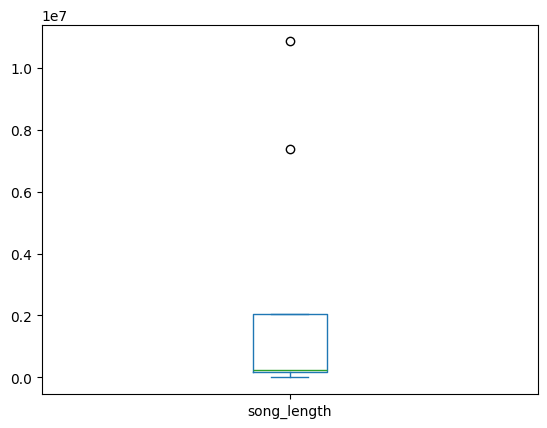

In [61]:
full_df['song_length'].describe(percentiles=[.2, .5, .8]).plot(kind='box')

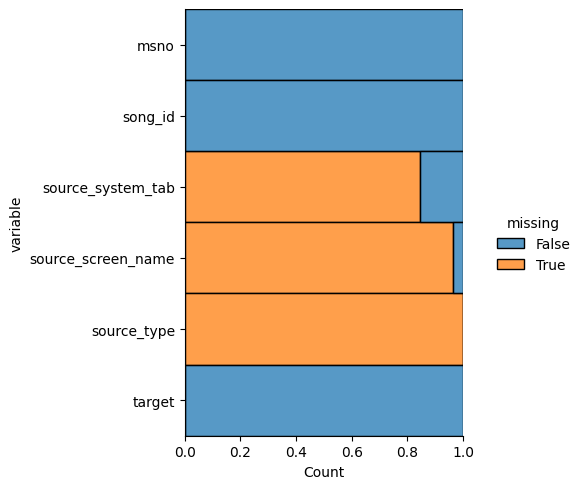

In [21]:
sns.displot(
    train_df[train_df['source_type'].isna()].isna().melt(value_name='missing'),
    y="variable",
    hue="missing",
    multiple="fill")

In [22]:
train_df['source_screen_name'].unique()

array(['Explore', 'Local playlist more', nan, 'My library',
       'Online playlist more', 'Album more', 'Discover Feature',
       'Unknown', 'Discover Chart', 'Radio', 'Artist more', 'Search',
       'Others profile more', 'Search Trends', 'Discover Genre',
       'My library_Search', 'Search Home', 'Discover New',
       'Self profile more', 'Concert', 'Payment'], dtype=object)

In [14]:
group_screen_name = train_df[train_df['source_screen_name'].isna()].groupby()

source_screen_name
Local playlist more     0.437579
Online playlist more    0.175494
Radio                   0.064313
Album more              0.056952
NaN                     0.056226
Search                  0.040460
Artist more             0.034216
Discover Feature        0.033107
Discover Chart          0.028961
Others profile more     0.027353
Discover Genre          0.011142
My library              0.010299
Explore                 0.009806
Unknown                 0.007343
Discover New            0.002163
Search Trends           0.001848
Search Home             0.001827
My library_Search       0.000874
Self profile more       0.000029
Concert                 0.000006
Payment                 0.000002
Name: proportion, dtype: float64

## Finetune

In [ ]:
!huggingface-cli delete-cache

In [85]:
tokenizer = BertTokenizer.from_pretrained(
    "uer/gpt2-distil-chinese-cluecorpussmall")
model = GPT2LMHeadModel.from_pretrained(
    "uer/gpt2-distil-chinese-cluecorpussmall")

tokenizer_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/244M [00:00<?, ?B/s]

In [3]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained(
    "miguelvictor/multilingual-gpt2-large")
model = AutoModelForCausalLM.from_pretrained(
    "miguelvictor/multilingual-gpt2-large")

config.json:   0%|          | 0.00/800 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

In [ ]:
class GPT4RecDataset(Dataset):

    def __init__(self, user_song: Dict[str, str], tokenizer: BertTokenizer) -> None:
        

In [4]:
with open('../data/user-song.json', 'r') as f:
    user_songs = json.load(f)

In [5]:
song_list = list(user_songs.values())

In [6]:
len(song_list)

30755

In [ ]:
prompt = """"""

In [7]:
''.join(tokenizer.convert_ids_to_tokens(tokenizer(song_list[0][0]).input_ids))

'æīĭå¿ĥçļĦèĸĶèĸĩĠ(Beautiful)Ġfeat.ĠG.E.M.éĦ§ç´«æ£ĭĠ->ĠæŀĹä¿ĬåĤĳĠ(JJĠLin)'

In [8]:
song_list[0][0]

'手心的薔薇 (Beautiful) feat. G.E.M.鄧紫棋 -> 林俊傑 (JJ Lin)'

In [112]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [113]:
''.join(
    gpt2_tokenizer.convert_ids_to_tokens(
        gpt2_tokenizer(song_list[0][0]).input_ids))

'æīĭå¿ĥçļĦèĸĶèĸĩĠ(Beautiful)Ġfeat.ĠG.E.M.éĦ§ç´«æ£ĭĠ->ĠæŀĹä¿ĬåĤĳĠ(JJĠLin)'

## Conclusion

[GPT4Rec](https://arxiv.org/pdf/2304.03879.pdf) is not suitable for this dataset because music's and artists' names are multi-lingual, which cannot be parsed by any monolingual GPT2 model.